In [1]:
#資料準備套件
import requests
import io
import pandas as pd
import time
import mplfinance as mpf

#畫圖套件
from matplotlib import dates as mdates
from matplotlib import ticker as mticker
from matplotlib.dates import DateFormatter
import mplfinance as mpf
import datetime as dt
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc

In [2]:
def repl(listo,ind,A,B): #資料phase1 簡化程式碼
    a = len(A)
    if listo[1][ind:ind+a] == A:
            listo[1] = listo[1][:ind] + B + listo[1][ind+a:]

In [3]:
def crawler( StockCode, yy, mm): #資料phase2 爬excel檔
    MM = lambda mm: '0' + str(mm) if mm < 10 else str(mm)
    page = requests.get('https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=csv&date='+ str(yy) + MM(mm) +'01&stockNo='+str(StockCode)).text.splitlines()
    
    for i, text in enumerate(page): #插入換行符
         page[i] = page[i][:-2] + '"\n'
  
    for i,text in enumerate(page): #找出資料終點
         if '/' == page[i][4:5]:
            end_point = i+1
    for i, text in enumerate(page): #找出資料起點
         if '/' == page[i][4:5]:
            start_point = i
            break 
            
    for i, text in enumerate(page):  #民國年換西元年      
        if page[i][4:5] == '/':
            page[i] =  page[i][:1] + str(int(page[i][1:4])+1911) + page[i][4:]
            
    for i in range(len(page[1])): #取代標題
        repl(page,i,'日期','Date')
        repl(page,i,'開盤價','Open')
        repl(page,i,'最高價','High')
        repl(page,i,'最低價','Low')
        repl(page,i,'收盤價','Close')
        repl(page,i,'成交股數','Volume')
        
    table = ''.join(list(page[start_point-1:end_point])) #把page(list)用join組合成一個字串
    table_df = pd.read_csv(io.StringIO(table), parse_dates=['Date'],index_col=0).dropna()
    #parse_date將table_df['日期']轉換成datetime形式，index_col=0是把第一欄當作索引值
    
    for i in range(len(table_df['Open'])):  #改變無數字的那筆資料
        if table_df['Open'][i] == '--':
            table_df['Open'][i] = table_df['Close'][i-1]
            table_df['High'][i] = table_df['Close'][i-1]
            table_df['Low'][i] = table_df['Close'][i-1]
            table_df['Close'][i] = table_df['Close'][i-1]
            #table_df = table_df.drop(index=table_df.index[i])-->比起刪掉那筆資料，還不如把資料變成昨日收盤價好@@
            
            
    for i in range(len(table_df['Volume'])): #把逗點去掉
        for j in range(len(table_df['Volume'][i])):
            if table_df['Volume'][i][j:j+1] == ',':
                table_df['Volume'][i] = table_df['Volume'][i][:j]  + table_df['Volume'][i][j+1:]

    table_df['Volume'] = table_df['Volume'].astype('int') #這個還是"str"object阿(用data['Volume'][0].dtype測的)，為什麼ax1v.fill_between就給過QQ 
    table_df['Open'] = table_df['Open'].astype('float')
    table_df['High'] = table_df['High'].astype('float')
    table_df['Low'] = table_df['Low'].astype('float')
    table_df['Close'] = table_df['Close'].astype('float')
    


    
    return table_df

In [4]:
#crawler(1216,2017,7)

In [5]:
def BigCrawler( StockCode, yy, mm, dd, YY, MM, DD): #phase3，小寫前時間，大寫後時間，合併多個excel檔

    Y_list = []
    YM_list = []
    
    yy = yy-1 #抓往前一年的資訊(也就是為了KD平滑，多抓了一年的資料)

    if type(yy) != int or type(YY) != int:
        print('請輸入數字！')

    elif YY > yy or YY == yy :
        for i in range((YY-yy)+1):
                years = yy+i
                Y_list.append(years)
        for i in range(len(Y_list)-1):
            while mm < 13 :
                temp = Y_list[i]*100 + mm
                mm += 1
                YM_list.append(str(temp))
            mm = 1
        while mm <= MM:
            temp = Y_list[-1]*100 + mm
            mm += 1
            YM_list.append(str(temp))

    elif YY < yy :
        print('過去年份大於近年年份！')

    #print(Y_list)   
    #print(YM_list)
    
    
    df = crawler(StockCode,int(YM_list[0][:4]),int(YM_list[0][-2:]))                 
    for i in range(1,len(YM_list)):
        time.sleep(5)
        df = pd.concat([df,crawler(StockCode,int(YM_list[i][:4]),int(YM_list[i][-2:]))])

    return df

In [6]:
def findIndex( data, yy, mm, dd): #資料，找出圖指定要的資料時間範圍
    month = lambda mm: '0' + str(mm) if mm < 10 else str(mm)
    day = lambda dd: '0' + str(dd) if dd < 10 else str(dd)
    dataIndex = []
    lenth = data.shape #輸出是一個tuple
    #print(lenth)

    for i in range(0,lenth[0]):
        if data.index[i] == pd.Timestamp(str(yy)+'-'+month(mm)+'-'+day(dd)+' 00:00:00'):
            ans = i
            break
            
        else:
            ans = '這天股市沒有交易！'

    return ans

In [7]:
def moving_average(data,periods):
    
    return data['Close'].rolling(periods).mean() #periods天的移動平均線

In [8]:
def KD(data):
    #計算Step1
    data_copy = data.copy()
    data_copy['min'] = data_copy['Low'].rolling(9).min()
    data_copy['max'] = data_copy['High'].rolling(9).max()
    for i in range(len(data_copy['Close'])):
        data_copy['Close'][i] = float(data_copy['Close'][i])
    data_copy['RSV'] = (data_copy['Close'] - data_copy['min'])/(data_copy['max'] - data_copy['min'])
    data_copy = data_copy.dropna() #濾除缺失數據,會整列濾除
    #計算Step2
    #K的起始值訂為50
    K_list = [50]

    for num,rsv in enumerate(list(data_copy['RSV'])):
        K_yesterday = K_list[num]
        K_today = 2/3 * K_yesterday + 1/3 * rsv
        K_list.append(K_today)
    data_copy['K'] = K_list[1:]
    D_list = [50]

    for num,K in enumerate(list(data_copy['K'])):
        D_yesterday = D_list[num]
        D_today = 2/3 * D_yesterday + 1/3 * K
        D_list.append(D_today)
    data_copy['D'] = D_list[1:]
    
    return data_copy

In [9]:
def PrepareData(data_df): 
    #資料，index認不得時間數據，所以要rearrange 做出新的一列Index，並將舊的時戳資料放成一欄
    data_df['DateTime'] = data_df.index
    data_df = data_df.reset_index()
    data_df = data_df[['DateTime','Open','High','Low','Close']]
    data_df['DateTime'] = mdates.date2num(data_df['DateTime'].astype('datetime64[ns]',dt.date))#astype要告訴它型態~(datetime64[ns])(dt.date)
    
    #將前8行刪掉，確保行數跟data一樣，才能畫圖表
    for i in range(0,8):
        data_df = data_df.drop(index=[i])
    
    return data_df

In [10]:
def diagram( data, data_df,yy,mm,dd,YY,MM,DD): #圖
    start = findIndex( data, yy, mm, dd) #選定的日期起點
    end = findIndex( data, YY, MM, DD)+1 #選定的日期終點
    Ma_5 = moving_average(data_df,5)
    Ma_10 = moving_average(data_df,10)
    Ma_20 = moving_average(data_df,20)
    Ma_60 = moving_average(data_df,60)
    Ma_120 = moving_average(data_df,120)
    Ma_Len = len(data_df['DateTime'])-(120-1) #配合Ma_120，也因為此行的關係資料一定要大於120畫圖才會正確
    fig = plt.figure(facecolor='white',figsize=(15,10))
    ax1 = plt.subplot2grid((6,4), (0,0),rowspan=4, colspan=4, facecolor='k')
    candlestick_ohlc(ax1, data_df.values[start:end],width=0.8,colorup='red',colordown='lime')
    ax1.plot(data_df['DateTime'].values[start:end],Ma_5[start:end],'yellow',label='5 MA Line', linewidth=1.2) 
    ax1.plot(data_df['DateTime'].values[start:end],Ma_10[start:end],'cyan',label='10 MA Line', linewidth=1.2)
    ax1.plot(data_df['DateTime'].values[start:end],Ma_20[start:end],'magenta',label='20 MA Line', linewidth=1.2)
    ax1.plot(data_df['DateTime'].values[start:end],Ma_60[start:end],'turquoise',label='60 MA Line', linewidth=1.2)
    ax1.plot(data_df['DateTime'].values[start:end],Ma_120[start:end],'tomato',label='120 MA Line', linewidth=1.2)
    #上面這行，第一個輸入為多個x，第二個輸入為多個y，會兩相一個一個對應
    ax1.legend(loc='lower left',ncol=2)
    ax1.grid(True, color='grey',linewidth=0.5) #把圖切成格子狀
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) #顯示出x軸的日期
    ax1.yaxis.label.set_color("black") #設置y軸標籤顏色
    plt.ylabel('Stock Price and Volume') #設置y軸標籤名字
    plt.suptitle('Stock Code %d'%StockCode,color='black',fontsize=20) #suptitle=Main figure title (但跟title有差嗎ˊˇˋ???? 小圖是用set_title阿ˊˇˋ???

    #畫交易量
    ax1v = ax1.twinx() #ax1共用x軸

    #ax1v.fill_between(data_df['DateTime'].values[start:end],0, data['Volume'].values[start:end], facecolor='navy', alpha=.4)
    #ax1v.fill_between畫交易量的圖形


    #以下不知道在幹嘛，只是複製
    #ax1v.axes.yaxis.set_ticklabels([])
    #ax1v.grid(False)
    #ax1v.set_ylim(0, 3*data.Volume.values.max())

    #加入KD線在下方
    ax2 = plt.subplot2grid((6,4), (4,0), sharex=ax1, rowspan=1, colspan=4, facecolor='black')
    ax2.plot(data_df['DateTime'].values[start:end],data['K'][start:end],label='K line',color='yellow')
    ax2.plot(data_df['DateTime'].values[start:end],data['D'][start:end],label='D Line',color='cyan')
    ax2.legend(loc='lower right', ncol=2)
    plt.ylabel('KD Value', color='black')

    ax3 = plt.subplot2grid((6,4), (5,0), sharex=ax1, rowspan=1, colspan=4, facecolor='black')
    ax3.plot(data_df['DateTime'].values[start:end],data['Volume'][start:end],label='V line',color='yellow')
    
    plt.show()

In [11]:
#抓資料
StockCode = 1216; yy = 2020; mm = 1; dd = 2; YY = 2020; MM = 4; DD = 22

data = BigCrawler(StockCode, yy, mm, dd, YY, MM, DD)
data_df = data[['Open','High','Low','Close']]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
#data.to_csv('data.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


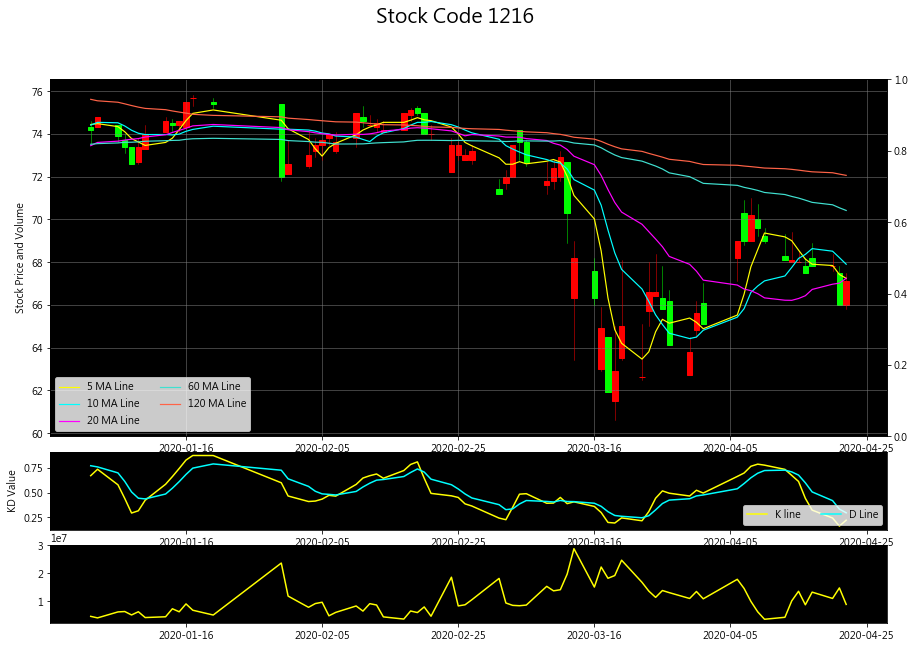

In [13]:
#資料準備及繪圖
data = KD( data) #畫KD、量的資料(當中也包含蠟燭身只是沒有用)
data_df = PrepareData( data_df)  #畫蠟燭身的資料
diagram( data, data_df, yy, mm, dd, YY, MM, DD)